# Introduction

<p style='font-size:16px;'>Millennials are reaching the ages of getting married and having children, which prompts them to buy their first homes. However, there are so many factors to take into account when it comes to picking a suitable neighborhood, such as housing prices, pre-k to 12 schools, etc. <br> <br>Therefore, this project will use location data well as real estate data in New York City to recommend suitable neighborhoods for purchasing homes for people, especially couples with the intention to raise their kids in NYC. In addition, these neighborhoods can also be of interest for real estate company who would like to develop new projects. </p>

# Data

<p style='font-size:16px;'> Location data from Foursquare API as well as real estate data from StreetEasy will be utilized for the analysis. <br><br> Real estate data, namely median sales price as well as inventory of houses in each neighborhood in New York City will be combined with location data that home purchasers are interested in, including categories such as school, Doctor's Office, Outdoors & Recreation, etc. 
</p>

### Location Data

<p style='font-size:16px;'>Coordinates of NYC neighborhood will be obtained from IBM dataset, and up to 100 venues within 1km radius from each neighborhood coordinate in the following categories will be selected:

<ul style='font-size:16px;'>
    <li> Food & Drink Shop </li> 
    <li> School </li> 
    <li> Medical Center </li> 
    <li> Outdoors & Recreation </li> 
    <li> Residence</li> 
</ul>
</p>

### Real Estate Data

<p style='font-size:16px;'> Average total inventory and median price of houses for sale in first quarter of 2020 in each neighborhood of NYC will be obtained from StreeEasy as csv files, which will be employed as features in addition to the data of various venues in each neighborhood. <br> <br> </p>

# Methodology

<p style='font-size:16px;'>First of all, we will import all the data and perform data cleaning. Afterwards, real estate data as well as location data will be merged into one data frame. After normalization, all the features will be fed to K-Means clustering algorithm for neighborhood segmentation, which will divide neighborhoods into k groups (the optimal k will be obtained after conducting elbow test) to facilitate the process of picking a suitable neighborhood to purchase a home.</p>

## Import Libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

# !conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from pandas import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import seaborn as sns

import requests

print('Libraries imported.') 

import matplotlib

matplotlib.rcParams["figure.dpi"] = 200

Libraries imported.


## Coordinates of New York CIty Neiborhoods 

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [4]:
neighborhoods_data = newyork_data['features']

In [5]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [6]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [7]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [8]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [9]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [10]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

<img src='map.png'>

## Real Estate Data

In [70]:
inventory = pd.read_csv('totalInventory_All.csv')

In [71]:
price = pd.read_csv('medianSalesPrice_All.csv')

In [72]:
df_inv = inventory[['areaName','Borough','2020-01','2020-02','2020-03']]
df_inv.head()

,areaName,Borough,2020-01,2020-02,2020-03
0,All Downtown,Manhattan,2680,2695,2560
1,All Midtown,Manhattan,2060,2082,2000
2,All Upper East Side,Manhattan,1938,1954,1863
3,All Upper Manhattan,Manhattan,723,711,682
4,All Upper West Side,Manhattan,1203,1198,1141


In [73]:
df_inv.shape

(198, 5)

In [74]:
df_inv = df_inv.assign(Q1=df_inv[['2020-01','2020-02','2020-03']].mean(axis=1))

In [75]:
df_inv[['areaName','Borough','Q1']].head()

,areaName,Borough,Q1
0,All Downtown,Manhattan,2645.000000
1,All Midtown,Manhattan,2047.333333
2,All Upper East Side,Manhattan,1918.333333
3,All Upper Manhattan,Manhattan,705.333333
4,All Upper West Side,Manhattan,1180.666667


In [76]:
df_price = price[['areaName','Borough','2020-01','2020-02','2020-03']]
df_price.head()

,areaName,Borough,2020-01,2020-02,2020-03
0,All Downtown,Manhattan,1395000.0,1262500.0,1300000.0
1,All Midtown,Manhattan,908000.0,1200000.0,910000.0
2,All Upper East Side,Manhattan,1093250.0,999000.0,925000.0
3,All Upper Manhattan,Manhattan,699000.0,687500.0,640000.0
4,All Upper West Side,Manhattan,1100000.0,1500000.0,1601871.5


In [77]:
df_price = df_price.assign(Q1 = df_price[['2020-01','2020-02','2020-03']].mean(axis=1,skipna=True,numeric_only=True))

In [78]:
df_price.head()

,areaName,Borough,2020-01,2020-02,2020-03,Q1
0,All Downtown,Manhattan,1395000.0,1262500.0,1300000.0,1.319167e+06
1,All Midtown,Manhattan,908000.0,1200000.0,910000.0,1.006000e+06
2,All Upper East Side,Manhattan,1093250.0,999000.0,925000.0,1.005750e+06
3,All Upper Manhattan,Manhattan,699000.0,687500.0,640000.0,6.755000e+05
4,All Upper West Side,Manhattan,1100000.0,1500000.0,1601871.5,1.400624e+06


In [79]:
df_price_q1 = df_price[['areaName','Borough','Q1']]

In [80]:
df_price_q1['Q1'].isna().sum()

60

### Fill missing Q1 values with Q4 2019 values

<p style='font-size:16px;'>As we can see, there are 60 neighborhoods who do not have data for Q1 2020. Therefore, we will use the average housing price for Q4 2019 to fill the missing values.</p>

In [81]:
df_price = df_price.assign(Q4=price[['2019-10','2019-11','2019-12']].mean(axis=1,skipna=True,numeric_only=True))

In [82]:
df_price.head()

,areaName,Borough,2020-01,2020-02,2020-03,Q1,Q4
0,All Downtown,Manhattan,1395000.0,1262500.0,1300000.0,1.319167e+06,1.412500e+06
1,All Midtown,Manhattan,908000.0,1200000.0,910000.0,1.006000e+06,9.026667e+05
2,All Upper East Side,Manhattan,1093250.0,999000.0,925000.0,1.005750e+06,9.800000e+05
3,All Upper Manhattan,Manhattan,699000.0,687500.0,640000.0,6.755000e+05,6.597838e+05
4,All Upper West Side,Manhattan,1100000.0,1500000.0,1601871.5,1.400624e+06,1.040833e+06


In [83]:
df_price.fillna(np.nan,inplace= True)

In [84]:
def nan_equal(a,b):
    try:
        np.testing.assert_equal(a,b)
    except AssertionError:
         return False
    return True

In [85]:
df_price = df_price.assign(Q1 = [df_price.loc[row,'Q4'] if (nan_equal(df_price.loc[row,'Q1'],np.nan)) 
                  else df_price.loc[row,'Q1'] for row in range(len(df_price['Q1']))])

In [86]:
df_price['Q1'].isna().sum()

47

### Fill remaining missing Q1 values of neighborhoods with average sales price in the borough

<p style='font-size:16px;'>After filling missing Q1 values with Q4 values, there are 47 remaining missing values. Therefore, I will use the average sales price of the borough that the neighborhood is in to fill the missing values.</p>

In [87]:
price_borough = df_price[df_price['areaName'].isin(['Bronx', 'Manhattan', 
                                                    'Queens', 'Brooklyn', 'Staten Island'])][['areaName','Q1']]

In [88]:
price_borough.set_index('areaName',inplace=True)

In [89]:
price_borough.sort_values(by='Q1',ascending=False, inplace=True)

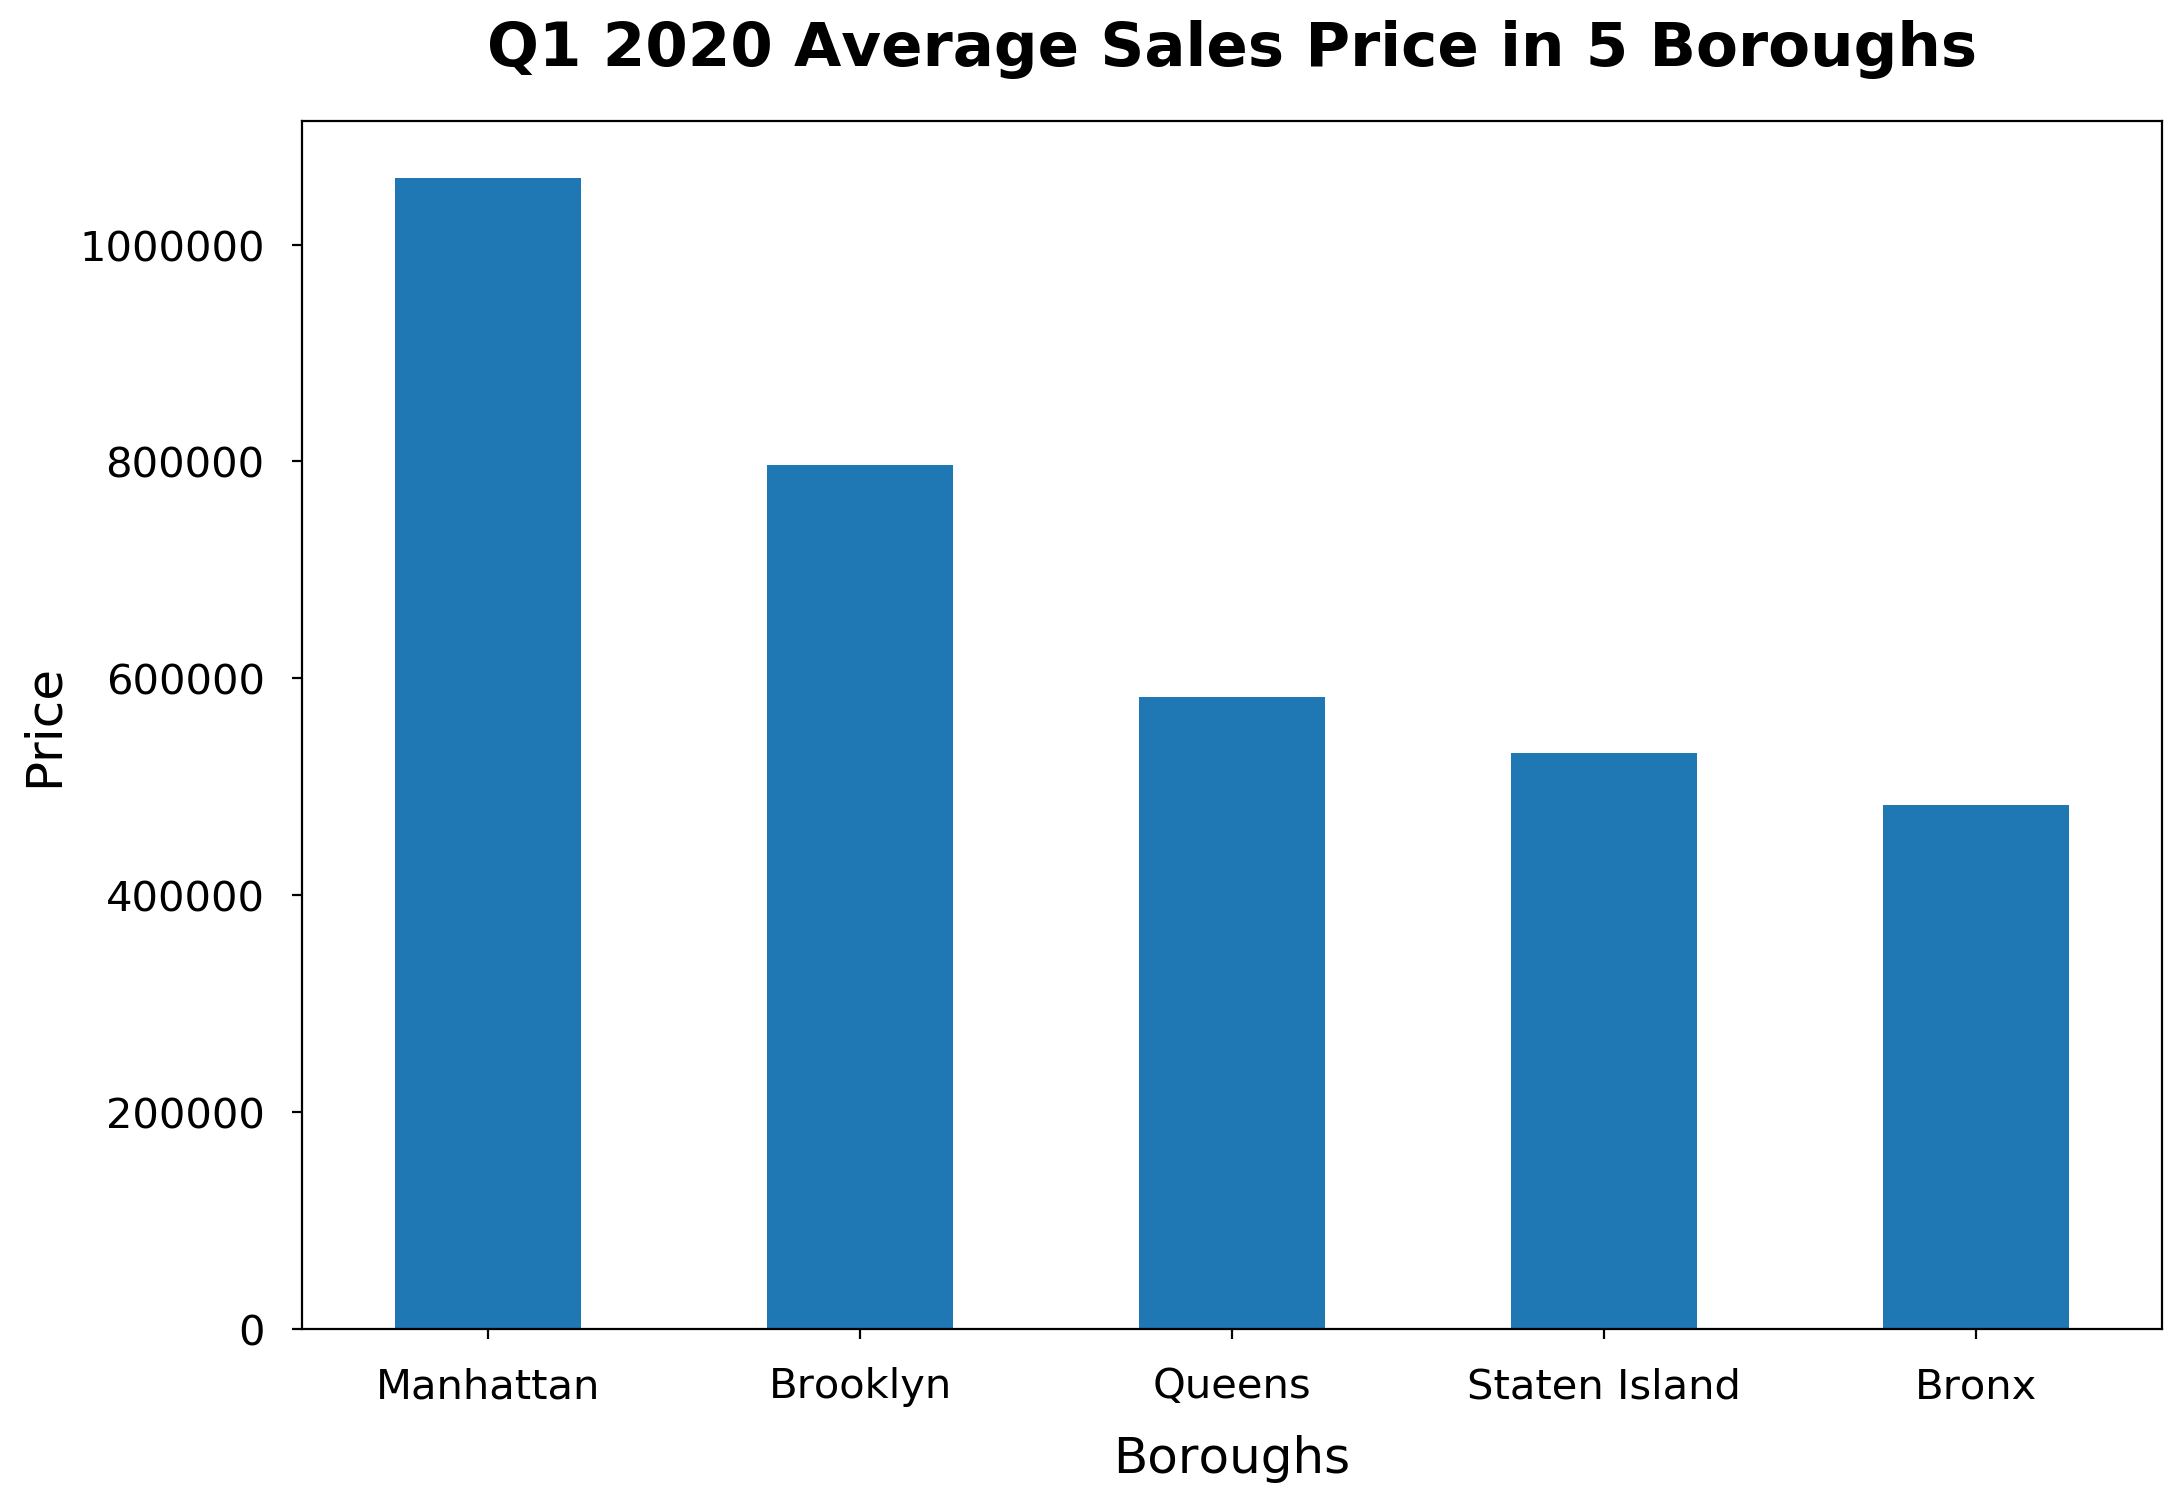

In [90]:
price_borough.plot(kind='bar',figsize=(12,8), fontsize=15, )
plt.title('Q1 2020 Average Sales Price in 5 Boroughs',fontdict={'fontsize':22,'fontweight':'bold'},pad=20)
plt.xlabel('Boroughs',fontdict={'fontsize':18},labelpad=10)
plt.ylabel('Price',fontdict={'fontsize':18})
plt.xticks(rotation=0)
plt.tick_params(pad=10)
plt.legend().remove()
plt.show()

In [91]:
def fill(x):
    if x['Borough'] == 'Bronx':
        return price_borough.loc['Bronx','Q1']
    if x['Borough'] == 'Brooklyn':
        return price_borough.loc['Brooklyn','Q1']
    if x['Borough'] == 'Manhattan':
        return price_borough.loc['Manhattan','Q1']
    if x['Borough'] == 'Queens':
        return price_borough.loc['Queens','Q1']
    else:
        return price_borough.loc['Staten Island','Q1']

In [92]:
temp = df_price[df_price['Q1'].isna()][['Borough','Q1']].apply(fill,axis=1)

In [93]:
df_price['Q1'].fillna(temp,inplace=True)

In [94]:
df_price.head()

,areaName,Borough,2020-01,2020-02,2020-03,Q1,Q4
0,All Downtown,Manhattan,1395000.0,1262500.0,1300000.0,1.319167e+06,1.412500e+06
1,All Midtown,Manhattan,908000.0,1200000.0,910000.0,1.006000e+06,9.026667e+05
2,All Upper East Side,Manhattan,1093250.0,999000.0,925000.0,1.005750e+06,9.800000e+05
3,All Upper Manhattan,Manhattan,699000.0,687500.0,640000.0,6.755000e+05,6.597838e+05
4,All Upper West Side,Manhattan,1100000.0,1500000.0,1601871.5,1.400624e+06,1.040833e+06


## Merge Data

In [95]:
new_price = df_price[['areaName','Q1']]
new_price.columns = ['areaName', 'price_Q1']

In [96]:
new_inventory = df_inv[['areaName','Q1']]
new_inventory.columns = ['areaName', 'inventory_Q1']

In [97]:
real_estate = pd.merge(new_price,new_inventory,on='areaName')
real_estate.head()

,areaName,price_Q1,inventory_Q1
0,All Downtown,1.319167e+06,2645.000000
1,All Midtown,1.006000e+06,2047.333333
2,All Upper East Side,1.005750e+06,1918.333333
3,All Upper Manhattan,6.755000e+05,705.333333
4,All Upper West Side,1.400624e+06,1180.666667


In [98]:
df = pd.merge(neighborhoods,real_estate,how='left', left_on='Neighborhood',right_on='areaName') 

In [99]:
df.dropna(inplace=True)

In [100]:
df.head()

,Borough,Neighborhood,Latitude,Longitude,areaName,price_Q1,inventory_Q1
0,Bronx,Wakefield,40.894705,-73.847201,Wakefield,533633.333333,25.333333
1,Bronx,Co-op City,40.874294,-73.829939,Co-op City,483300.000000,1.000000
2,Bronx,Eastchester,40.887556,-73.827806,Eastchester,483300.000000,2.000000
4,Bronx,Riverdale,40.890834,-73.912585,Riverdale,300833.333333,312.333333
5,Bronx,Kingsbridge,40.881687,-73.902818,Kingsbridge,305000.000000,21.000000


<p style='font-size:16px;'>Remove neighborhoods in Staten Island as we do not have Q1 real estate data for them.

In [101]:
df[df['Borough']=='Staten Island']

,Borough,Neighborhood,Latitude,Longitude,areaName,price_Q1,inventory_Q1
220,Staten Island,Sunnyside,40.612760,-74.097126,Sunnyside,453640.000000,64.000000
244,Staten Island,Chelsea,40.594726,-74.189560,Chelsea,999833.333333,362.333333


In [102]:
df.drop(index=[220,244],inplace=True)

In [103]:
df.shape

(151, 7)

## Foursquare Location Data

In [104]:
CLIENT_ID = 'WTX51FOFEC13QKAK2Q3A2XFQ0MG4CDMFXQMSGCMUTXJDIMMH' # your Foursquare ID
CLIENT_SECRET = '21E1MLYXMJLA3JWOMWOCVMPJ4DWG4VXXJQD0FOFF1JUEASMP' # your Foursquare Secret
VERSION = '20200607' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: WTX51FOFEC13QKAK2Q3A2XFQ0MG4CDMFXQMSGCMUTXJDIMMH
CLIENT_SECRET:21E1MLYXMJLA3JWOMWOCVMPJ4DWG4VXXJQD0FOFF1JUEASMP


In [105]:
neighborhood_latitude = df.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = df.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Wakefield are 40.89470517661, -73.84720052054902.


In [106]:
category=["4bf58dd8d48988d1f9941735","4bf58dd8d48988d13b941735",
          "4bf58dd8d48988d104941735","4d4b7105d754a06377d81259","4e67e38e036454776db1fb3a"]

In [109]:
venue_dic ={}

In [111]:
radius = 1000
LIMIT = 100
def get_count(names,lats,lngs):
    for name, lat, lng in zip(names,lats,lngs):
        print(name)
        dictionary = {}
        for categoryId in category:
            url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}&categoryId={}'.format(CLIENT_ID, CLIENT_SECRET, lat, 
                                                                                                                               lng, VERSION, radius, LIMIT, categoryId)
            results = requests.get(url).json()
#             print(results)
            dictionary[results["response"]['query']] = results["response"]['totalResults']
        venue_dic[name] = dictionary
    return venue_dic

In [112]:
df1 = df.reset_index().drop('index',axis=1)

In [540]:
get_count(df1.loc['Neighborhood'],df1.loc['Latitude'],df1.loc['Longitude'])

Chelsea
Sunnyside


{'Wakefield': {'food drink': 14,
  'school': 7,
  'medical': 14,
  'outdoors recreation': 5,
  'residence': 7},
 'Co-op City': {'food drink': 10,
  'school': 8,
  'medical': 32,
  'outdoors recreation': 15,
  'residence': 5},
 'Eastchester': {'food drink': 13,
  'school': 6,
  'medical': 7,
  'outdoors recreation': 5,
  'residence': 3},
 'Riverdale': {'food drink': 8,
  'school': 15,
  'medical': 44,
  'outdoors recreation': 29,
  'residence': 6},
 'Kingsbridge': {'food drink': 34,
  'school': 36,
  'medical': 67,
  'outdoors recreation': 55,
  'residence': 7},
 'Marble Hill': {'food drink': 30,
  'school': 38,
  'medical': 71,
  'outdoors recreation': 45,
  'residence': 11},
 'Woodlawn': {'food drink': 12,
  'school': 6,
  'medical': 20,
  'outdoors recreation': 10,
  'residence': 5},
 'Norwood': {'food drink': 25,
  'school': 25,
  'medical': 87,
  'outdoors recreation': 33,
  'residence': 2},
 'Williamsbridge': {'food drink': 23,
  'school': 29,
  'medical': 19,
  'outdoors recreati

In [113]:
df1.shape

(151, 7)

In [114]:
len(venue_dic)

151

In [116]:
new_df = pd.DataFrame(venue_dic).T
new_df

,food drink,school,medical,outdoors recreation,residence
Wakefield,14,7,14,5,7
Co-op City,10,8,32,15,5
Eastchester,13,6,7,5,3
Riverdale,8,15,44,29,6
Kingsbridge,34,36,67,55,7
Marble Hill,30,38,71,45,11
Woodlawn,12,6,20,10,5
Norwood,25,25,87,33,2
Williamsbridge,23,29,19,7,6
Baychester,12,16,64,12,4


In [117]:
final_df = pd.merge(df1,new_df.reset_index(),left_on='Neighborhood',right_on='index').iloc[:,-8:].drop('index',axis=1) 

<p style='font-size:16px;'>The final dataframe without indicating neighborhoods looks like this:

In [118]:
final_df.head()

,price_Q1,inventory_Q1,food drink,school,medical,outdoors recreation,residence
0,533633.333333,25.333333,14,7,14,5,7
1,483300.000000,1.000000,10,8,32,15,5
2,483300.000000,2.000000,13,6,7,5,3
3,300833.333333,312.333333,8,15,44,29,6
4,305000.000000,21.000000,34,36,67,55,7


# Results

<p style='font-size:16px;'>Now, we will use <strong>K-means</strong> to perform clustering to our dataframe.</p>

In [119]:
from sklearn.preprocessing import StandardScaler

In [121]:
from sklearn.metrics import calinski_harabasz_score

### Normalization

In [120]:
final = StandardScaler().fit_transform(final_df)

In [126]:
k_dict = {}
for i in range(2,10):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(final)
    score = calinski_harabasz_score(final_df,kmeans.labels_)
    k_dict[i] = score
    print('When k={}, the score is '.format(i),score)

When k=2, the score is  109.35094575751953
When k=3, the score is  70.39887159429081
When k=4, the score is  46.215237011733024
When k=5, the score is  101.01220619149737
When k=6, the score is  80.48854039227925
When k=7, the score is  67.33222044733489
When k=8, the score is  62.64100232199294
When k=9, the score is  63.36709889470342


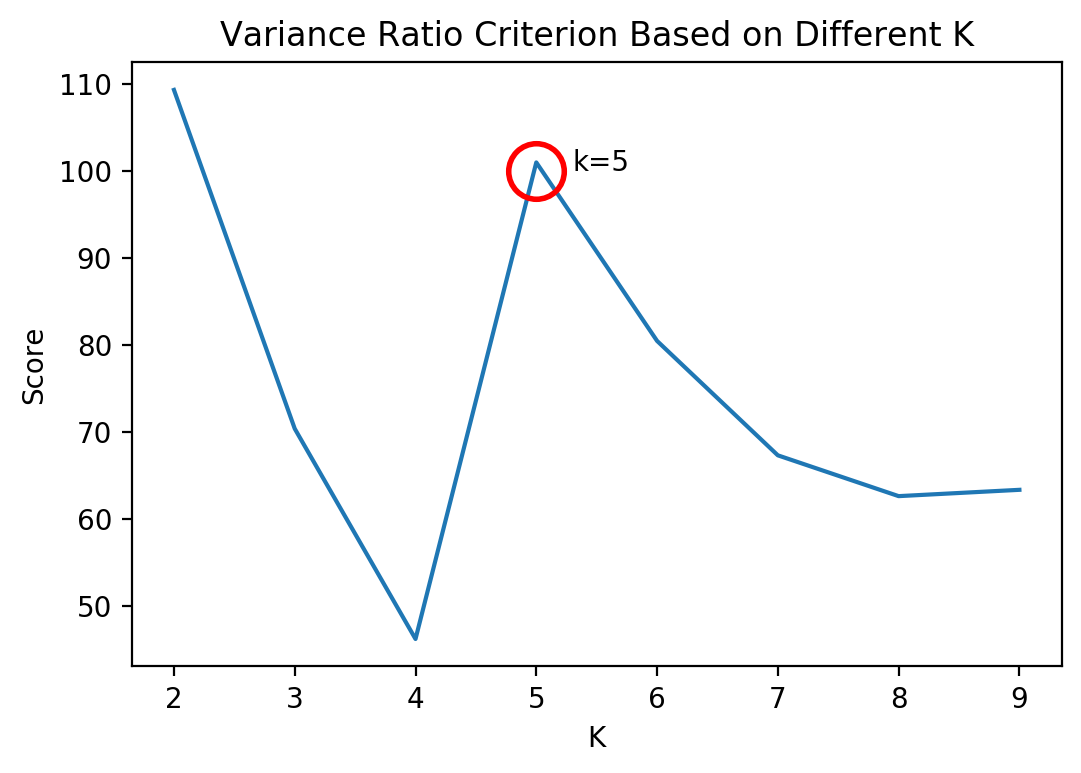

In [146]:
plt.plot(pd.Series(k_dict))
plt.xlabel('K')
plt.ylabel('Score')
plt.title('Variance Ratio Criterion Based on Different K')
plt.plot(5, 100, 'o',
        ms=20, mec='r', mfc='none', mew=2)
plt.text(5.3,100,'k=5')
plt.show()

In [551]:
# run k-means clustering
kmeans = KMeans(n_clusters=5, random_state=0).fit(final)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 4, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 4, 0, 1, 1, 1, 0, 4, 0, 1, 0, 0, 0, 3, 0, 3, 2, 4, 4,
       4, 0, 2, 4, 2, 4, 0, 4, 4, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 1, 1, 1, 1, 4, 1],
      dtype=int32)

In [552]:
cluster1 = pd.merge(df1,new_df.reset_index(),left_on='Neighborhood',right_on='index')

In [553]:
cluster1.insert(0, 'Cluster Labels', kmeans.labels_)


In [554]:
cluster1.head()

,Cluster Labels,Borough,Neighborhood,Latitude,Longitude,areaName,price_Q1,inventory_Q1,index,food drink,school,medical,outdoors recreation,residence
0,1,Bronx,Wakefield,40.894705,-73.847201,Wakefield,5.336333e+05,25.333333,Wakefield,14,7,14,5,7
1,1,Bronx,Co-op City,40.874294,-73.829939,Co-op City,4.833000e+05,1.000000,Co-op City,10,8,32,15,5
2,1,Bronx,Eastchester,40.887556,-73.827806,Eastchester,4.833000e+05,2.000000,Eastchester,13,6,7,5,3
3,1,Bronx,Riverdale,40.890834,-73.912585,Riverdale,3.008333e+05,312.333333,Riverdale,8,15,44,29,6
4,1,Bronx,Kingsbridge,40.881687,-73.902818,Kingsbridge,3.050000e+05,21.000000,Kingsbridge,34,36,67,55,7
5,0,Manhattan,Marble Hill,40.876551,-73.910660,Marble Hill,1.061275e+06,0.000000,Marble Hill,30,38,71,45,11
6,1,Bronx,Woodlawn,40.898273,-73.867315,Woodlawn,4.833000e+05,1.333333,Woodlawn,12,6,20,10,5
7,1,Bronx,Norwood,40.877224,-73.879391,Norwood,4.833000e+05,5.000000,Norwood,25,25,87,33,2
8,1,Bronx,Williamsbridge,40.881039,-73.857446,Williamsbridge,6.283333e+05,21.000000,Williamsbridge,23,29,19,7,6
9,1,Bronx,Baychester,40.866858,-73.835798,Baychester,4.833000e+05,5.333333,Baychester,12,16,64,12,4


### Plotting Different Clusters

In [555]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(5)
ys = [i + x + (i*x)**2 for i in range(5)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cluster1['Latitude'], cluster1['Longitude'], cluster1['Neighborhood'], cluster1['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<img src='nyc1.png'></img>

### Clusters

In [561]:
cluster_1 = cluster1.loc[cluster1['Cluster Labels'] == 0, cluster1.columns[[1] + list(range(5, cluster1.shape[1]))]]

In [562]:
cluster_1.head()

,Borough,areaName,price_Q1,inventory_Q1,index,food drink,school,medical,outdoors recreation,residence
5,Manhattan,Marble Hill,1.061275e+06,0.000000,Marble Hill,30,38,71,45,11
36,Brooklyn,Bay Ridge,7.119167e+05,261.000000,Bay Ridge,54,18,149,48,5
37,Brooklyn,Bensonhurst,1.098333e+06,82.000000,Bensonhurst,42,34,96,22,8
38,Brooklyn,Sunset Park,9.425000e+05,108.000000,Sunset Park,67,25,119,20,14
39,Brooklyn,Greenpoint,1.200000e+06,80.333333,Greenpoint,62,16,62,77,12
42,Brooklyn,Sheepshead Bay,5.785000e+05,335.000000,Sheepshead Bay,25,13,101,52,6
44,Brooklyn,Crown Heights,1.103301e+06,163.666667,Crown Heights,65,44,52,21,9
46,Brooklyn,Kensington,9.154060e+05,83.000000,Kensington,37,18,70,25,31
47,Brooklyn,Windsor Terrace,1.032500e+06,41.333333,Windsor Terrace,22,23,39,63,27
48,Brooklyn,Prospect Heights,1.127500e+06,63.000000,Prospect Heights,86,46,120,113,16


---

In [563]:
cluster_2 = cluster1.loc[cluster1['Cluster Labels'] == 1, cluster1.columns[[1] + list(range(5, cluster1.shape[1]))]]

In [564]:
cluster_2

,Borough,areaName,price_Q1,inventory_Q1,index,food drink,school,medical,outdoors recreation,residence
0,Bronx,Wakefield,5.336333e+05,25.333333,Wakefield,14,7,14,5,7
1,Bronx,Co-op City,4.833000e+05,1.000000,Co-op City,10,8,32,15,5
2,Bronx,Eastchester,4.833000e+05,2.000000,Eastchester,13,6,7,5,3
3,Bronx,Riverdale,3.008333e+05,312.333333,Riverdale,8,15,44,29,6
4,Bronx,Kingsbridge,3.050000e+05,21.000000,Kingsbridge,34,36,67,55,7
6,Bronx,Woodlawn,4.833000e+05,1.333333,Woodlawn,12,6,20,10,5
7,Bronx,Norwood,4.833000e+05,5.000000,Norwood,25,25,87,33,2
8,Bronx,Williamsbridge,6.283333e+05,21.000000,Williamsbridge,23,29,19,7,6
9,Bronx,Baychester,4.833000e+05,5.333333,Baychester,12,16,64,12,4
10,Bronx,Pelham Parkway,4.833000e+05,4.333333,Pelham Parkway,14,24,76,18,4


---

In [565]:
cluster_3 = cluster1.loc[cluster1['Cluster Labels'] == 2, cluster1.columns[[1] + list(range(5, cluster1.shape[1]))]]

In [566]:
cluster_3

,Borough,areaName,price_Q1,inventory_Q1,index,food drink,school,medical,outdoors recreation,residence
85,Manhattan,Midtown,3.037443e+06,393.666667,Midtown,183,168,196,187,59
90,Manhattan,Tribeca,3.079458e+06,291.333333,Tribeca,89,68,123,157,28
92,Manhattan,Soho,2.402942e+06,192.666667,Soho,181,114,159,192,31


---

In [567]:
cluster_4 = cluster1.loc[cluster1['Cluster Labels'] == 3, cluster1.columns[[1] + list(range(5, cluster1.shape[1]))]]

In [568]:
cluster_4

,Borough,areaName,price_Q1,inventory_Q1,index,food drink,school,medical,outdoors recreation,residence
82,Manhattan,Upper East Side,1.005750e+06,1918.333333,Upper East Side,97,81,200,133,40
84,Manhattan,Upper West Side,1.400624e+06,1180.666667,Upper West Side,67,101,138,110,40


---

In [569]:
cluster_5 = cluster1.loc[cluster1['Cluster Labels'] == 4, cluster1.columns[[1] + list(range(5, cluster1.shape[1]))]]

In [570]:
cluster_5

,Borough,areaName,price_Q1,inventory_Q1,index,food drink,school,medical,outdoors recreation,residence
52,Brooklyn,Brooklyn Heights,1.212583e+06,147.333333,Brooklyn Heights,70,61,167,165,40
70,Brooklyn,Boerum Hill,1.835000e+06,50.666667,Boerum Hill,101,81,136,140,48
76,Manhattan,Chinatown,1.061275e+06,18.000000,Chinatown,190,115,151,151,36
86,Manhattan,Chelsea,9.998333e+05,362.333333,Chelsea,120,100,139,150,53
87,Manhattan,Greenwich Village,1.153750e+06,277.000000,Greenwich Village,163,113,130,159,37
88,Manhattan,East Village,8.300000e+05,112.333333,East Village,143,109,125,142,51
91,Manhattan,Little Italy,1.061275e+06,4.333333,Little Italy,188,116,153,163,28
93,Manhattan,West Village,1.401875e+06,232.000000,West Village,132,85,136,145,34
95,Manhattan,Battery Park City,1.412749e+06,116.666667,Battery Park City,88,89,202,162,73
96,Manhattan,Financial District,1.009927e+06,377.333333,Financial District,102,96,215,167,76


# Discussion

In [574]:
df_compare = cluster1.groupby('Cluster Labels').mean()

In [575]:
df_compare

,Latitude,Longitude,price_Q1,inventory_Q1,food drink,school,medical,outdoors recreation,residence
Cluster Labels,,,,,,,,,
0,40.710800,-73.950215,8.966918e+05,121.207207,56.729730,36.405405,110.918919,61.810811,16.945946
1,40.749506,-73.855384,5.773324e+05,38.347222,18.781250,16.864583,40.416667,17.645833,5.614583
2,40.732799,-73.997670,2.839947e+06,292.555556,151.000000,116.666667,159.333333,178.666667,39.333333
3,40.781648,-73.968783,1.203187e+06,1549.500000,82.000000,91.000000,169.000000,121.500000,40.000000
4,40.720938,-73.997935,1.213384e+06,156.358974,142.692308,115.384615,164.307692,162.153846,52.538462


In [577]:
df_compare.reset_index(inplace=True)

In [633]:
cluster1

,Cluster Labels,Borough,Neighborhood,Latitude,Longitude,areaName,price_Q1,inventory_Q1,index,food drink,school,medical,outdoors recreation,residence,facilities
0,1,Bronx,Wakefield,40.894705,-73.847201,Wakefield,5.336333e+05,25.333333,Wakefield,14,7,14,5,7,47
1,1,Bronx,Co-op City,40.874294,-73.829939,Co-op City,4.833000e+05,1.000000,Co-op City,10,8,32,15,5,70
2,1,Bronx,Eastchester,40.887556,-73.827806,Eastchester,4.833000e+05,2.000000,Eastchester,13,6,7,5,3,34
3,1,Bronx,Riverdale,40.890834,-73.912585,Riverdale,3.008333e+05,312.333333,Riverdale,8,15,44,29,6,102
4,1,Bronx,Kingsbridge,40.881687,-73.902818,Kingsbridge,3.050000e+05,21.000000,Kingsbridge,34,36,67,55,7,199
5,0,Manhattan,Marble Hill,40.876551,-73.910660,Marble Hill,1.061275e+06,0.000000,Marble Hill,30,38,71,45,11,195
6,1,Bronx,Woodlawn,40.898273,-73.867315,Woodlawn,4.833000e+05,1.333333,Woodlawn,12,6,20,10,5,53
7,1,Bronx,Norwood,40.877224,-73.879391,Norwood,4.833000e+05,5.000000,Norwood,25,25,87,33,2,172
8,1,Bronx,Williamsbridge,40.881039,-73.857446,Williamsbridge,6.283333e+05,21.000000,Williamsbridge,23,29,19,7,6,84
9,1,Bronx,Baychester,40.866858,-73.835798,Baychester,4.833000e+05,5.333333,Baychester,12,16,64,12,4,108


In [587]:
cluster1['facilities'] = [cluster1.iloc[r,-5:].sum() for r in range(len(cluster1))]

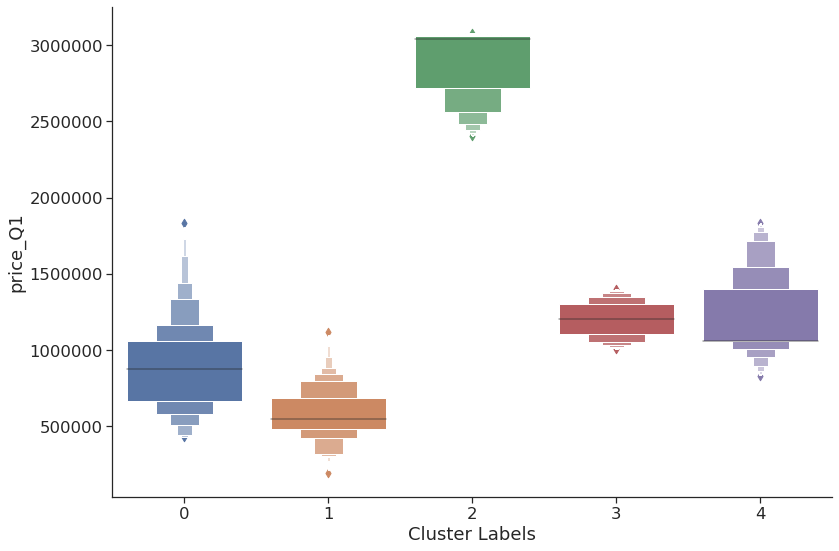

In [619]:
sns.catplot(data=cluster1,x='Cluster Labels',aspect=1.5, height=8,y='price_Q1',kind='boxen')

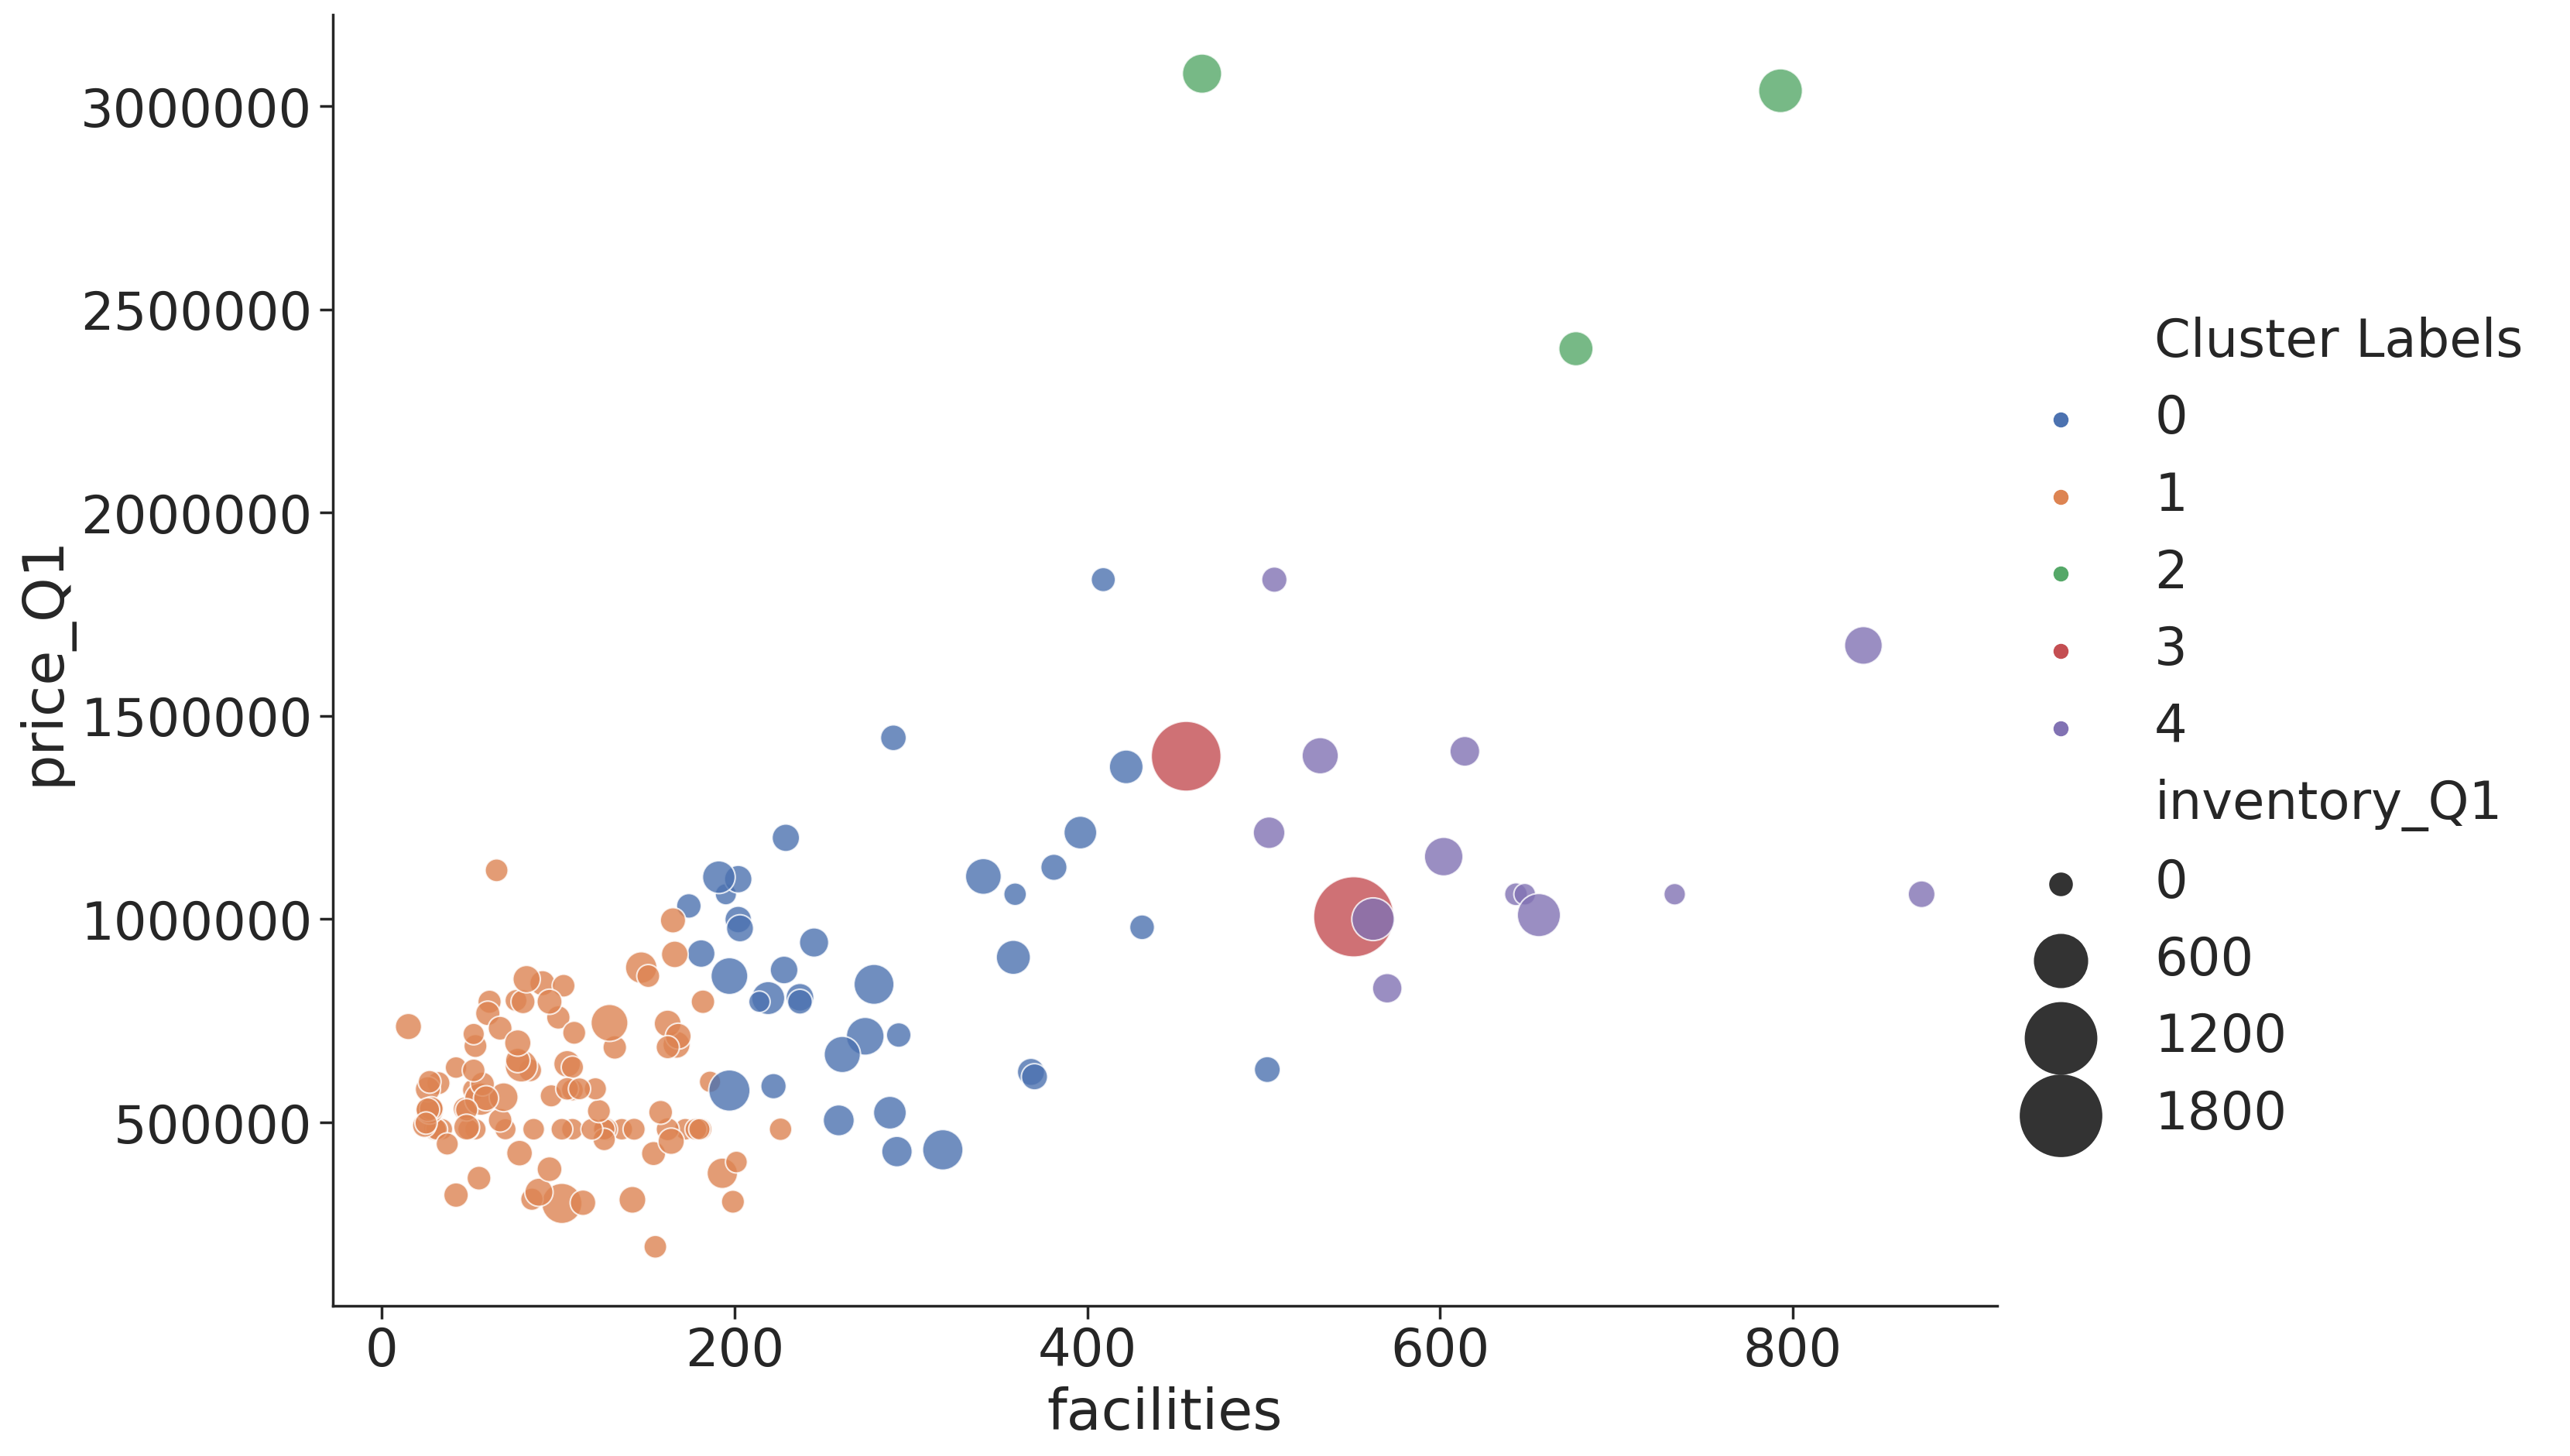

In [761]:
sns.set(style='ticks',font_scale=2.2)
ax = sns.relplot(data=cluster1, x='facilities',y='price_Q1',palette="deep",alpha=0.8,
            size='inventory_Q1',aspect=1.4,height=10,hue='Cluster Labels',sizes=(100,1400),size_norm=(0,1600))

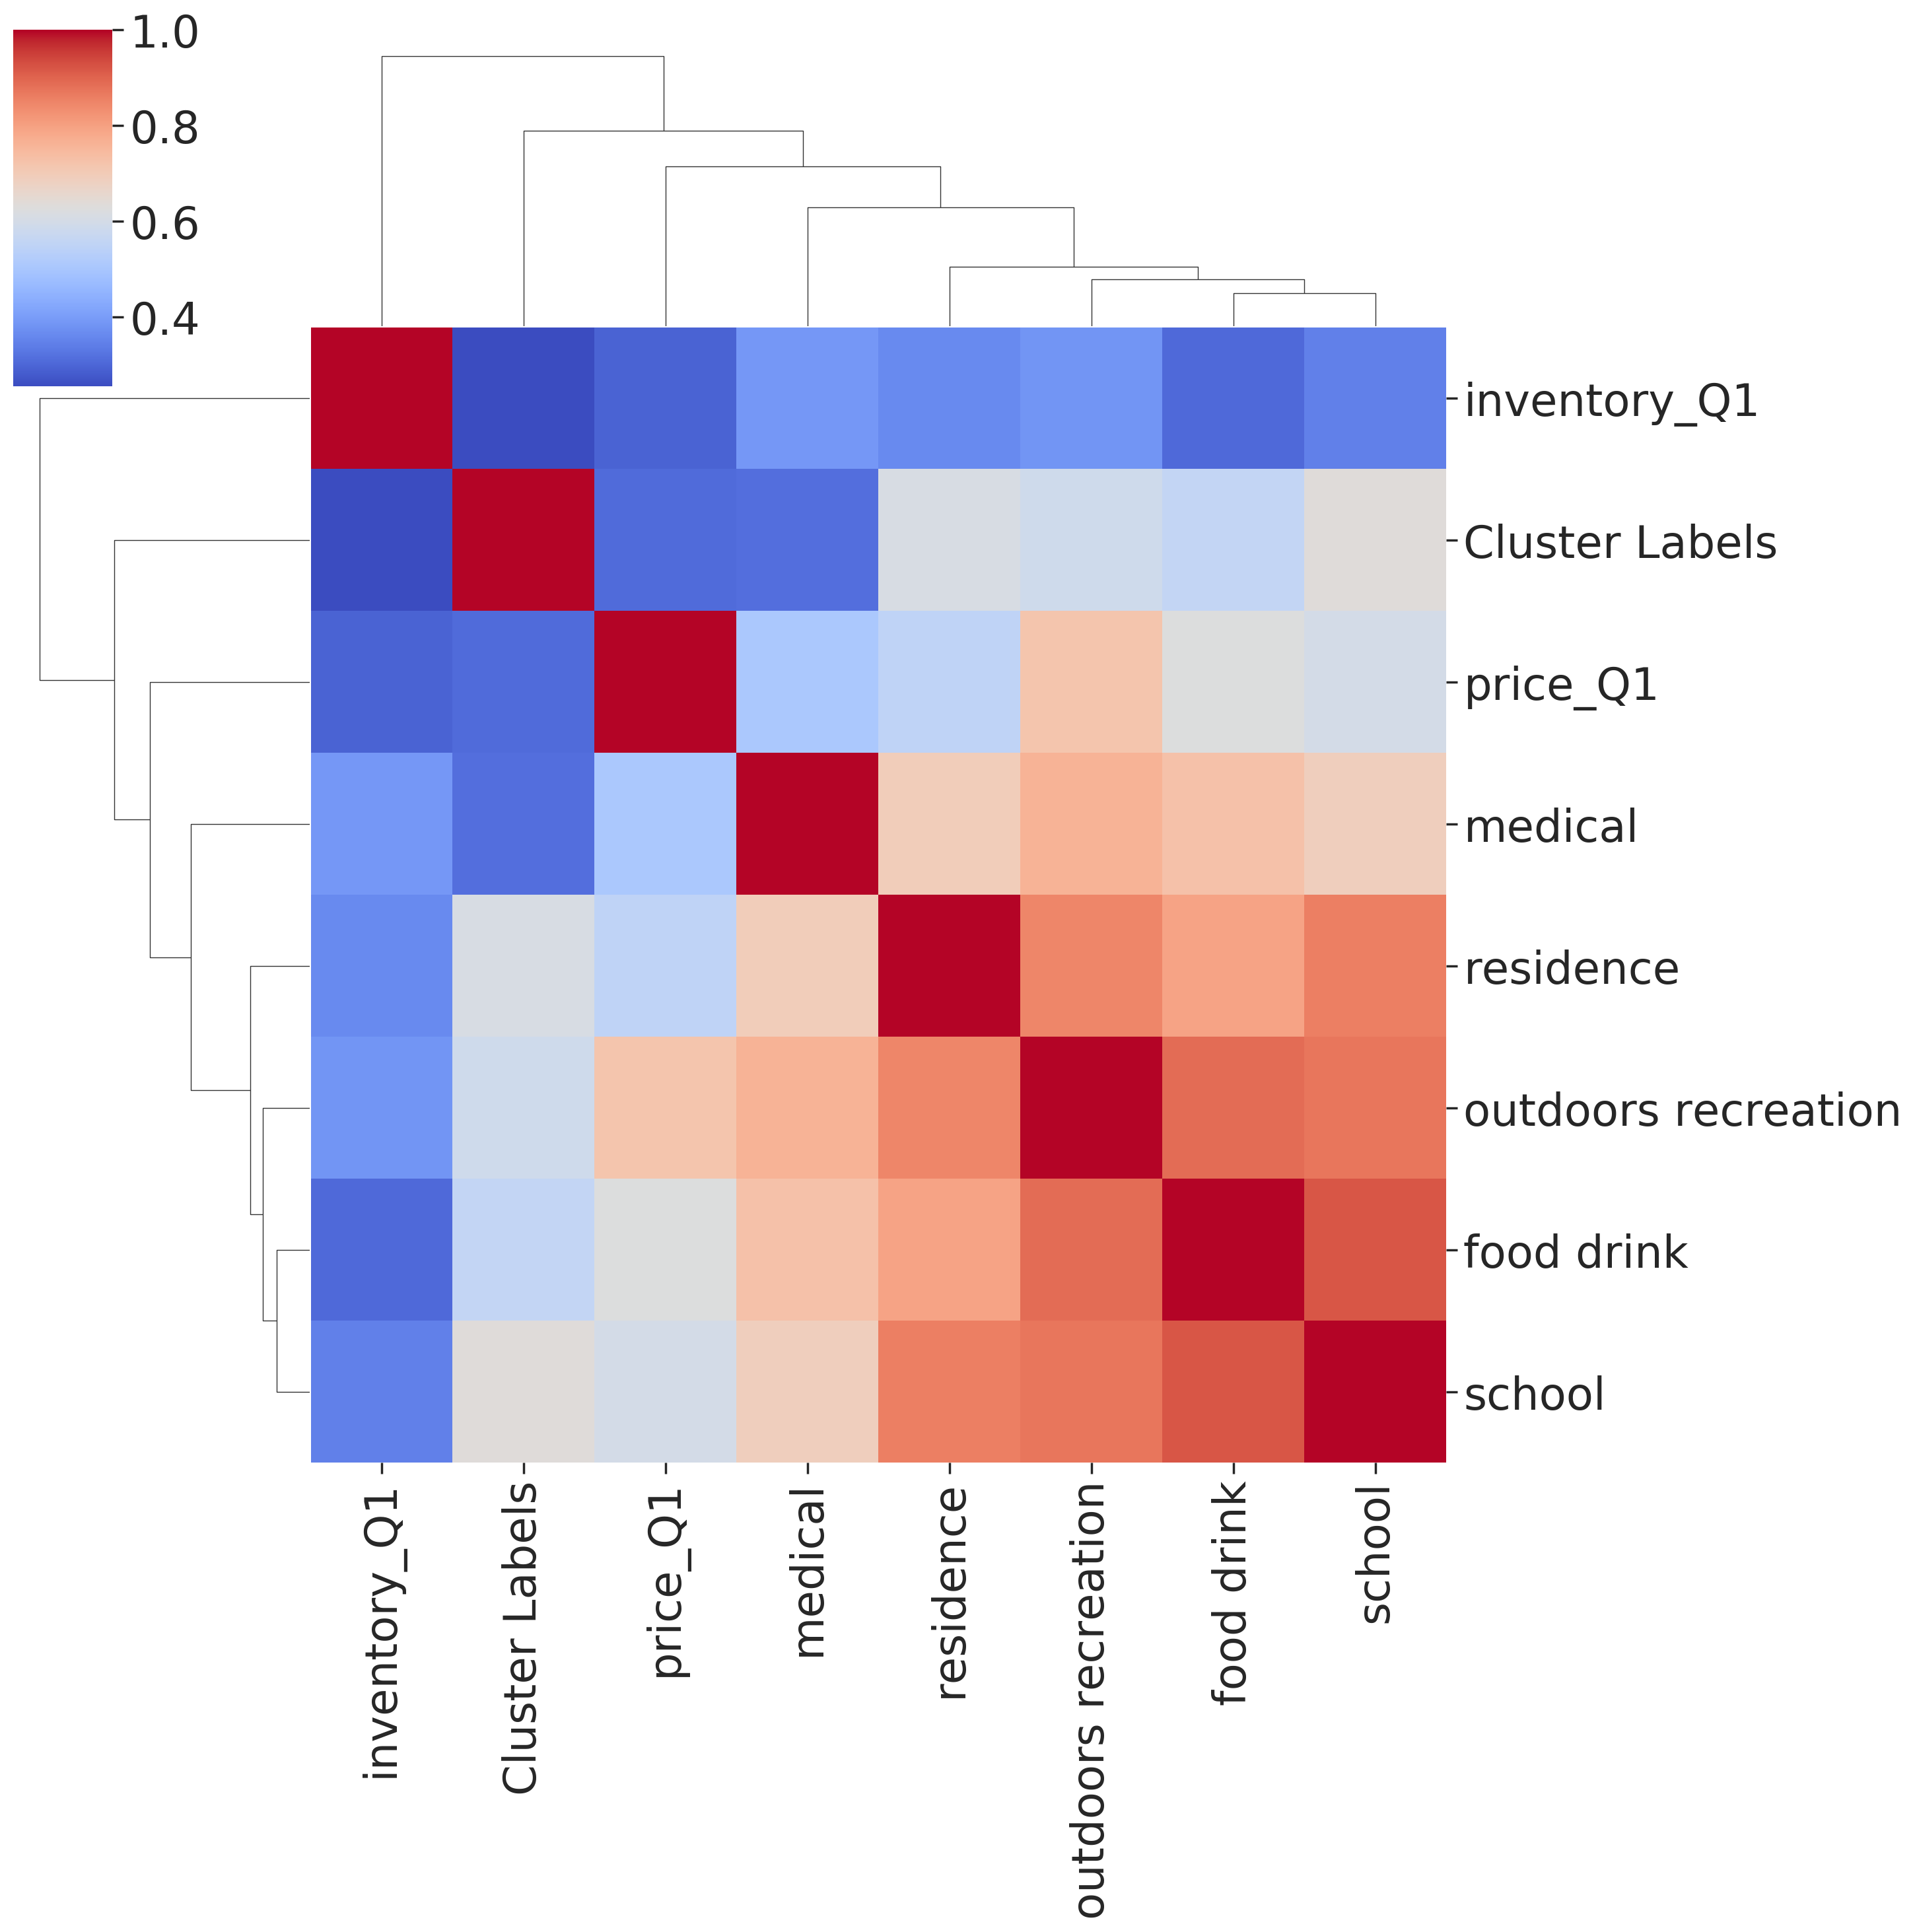

In [762]:
sns.clustermap(cluster1[['Cluster Labels','price_Q1',
                       'inventory_Q1','food drink','school',
                       'medical','outdoors recreation','residence']].corr(),cmap='coolwarm',figsize=(15,15))

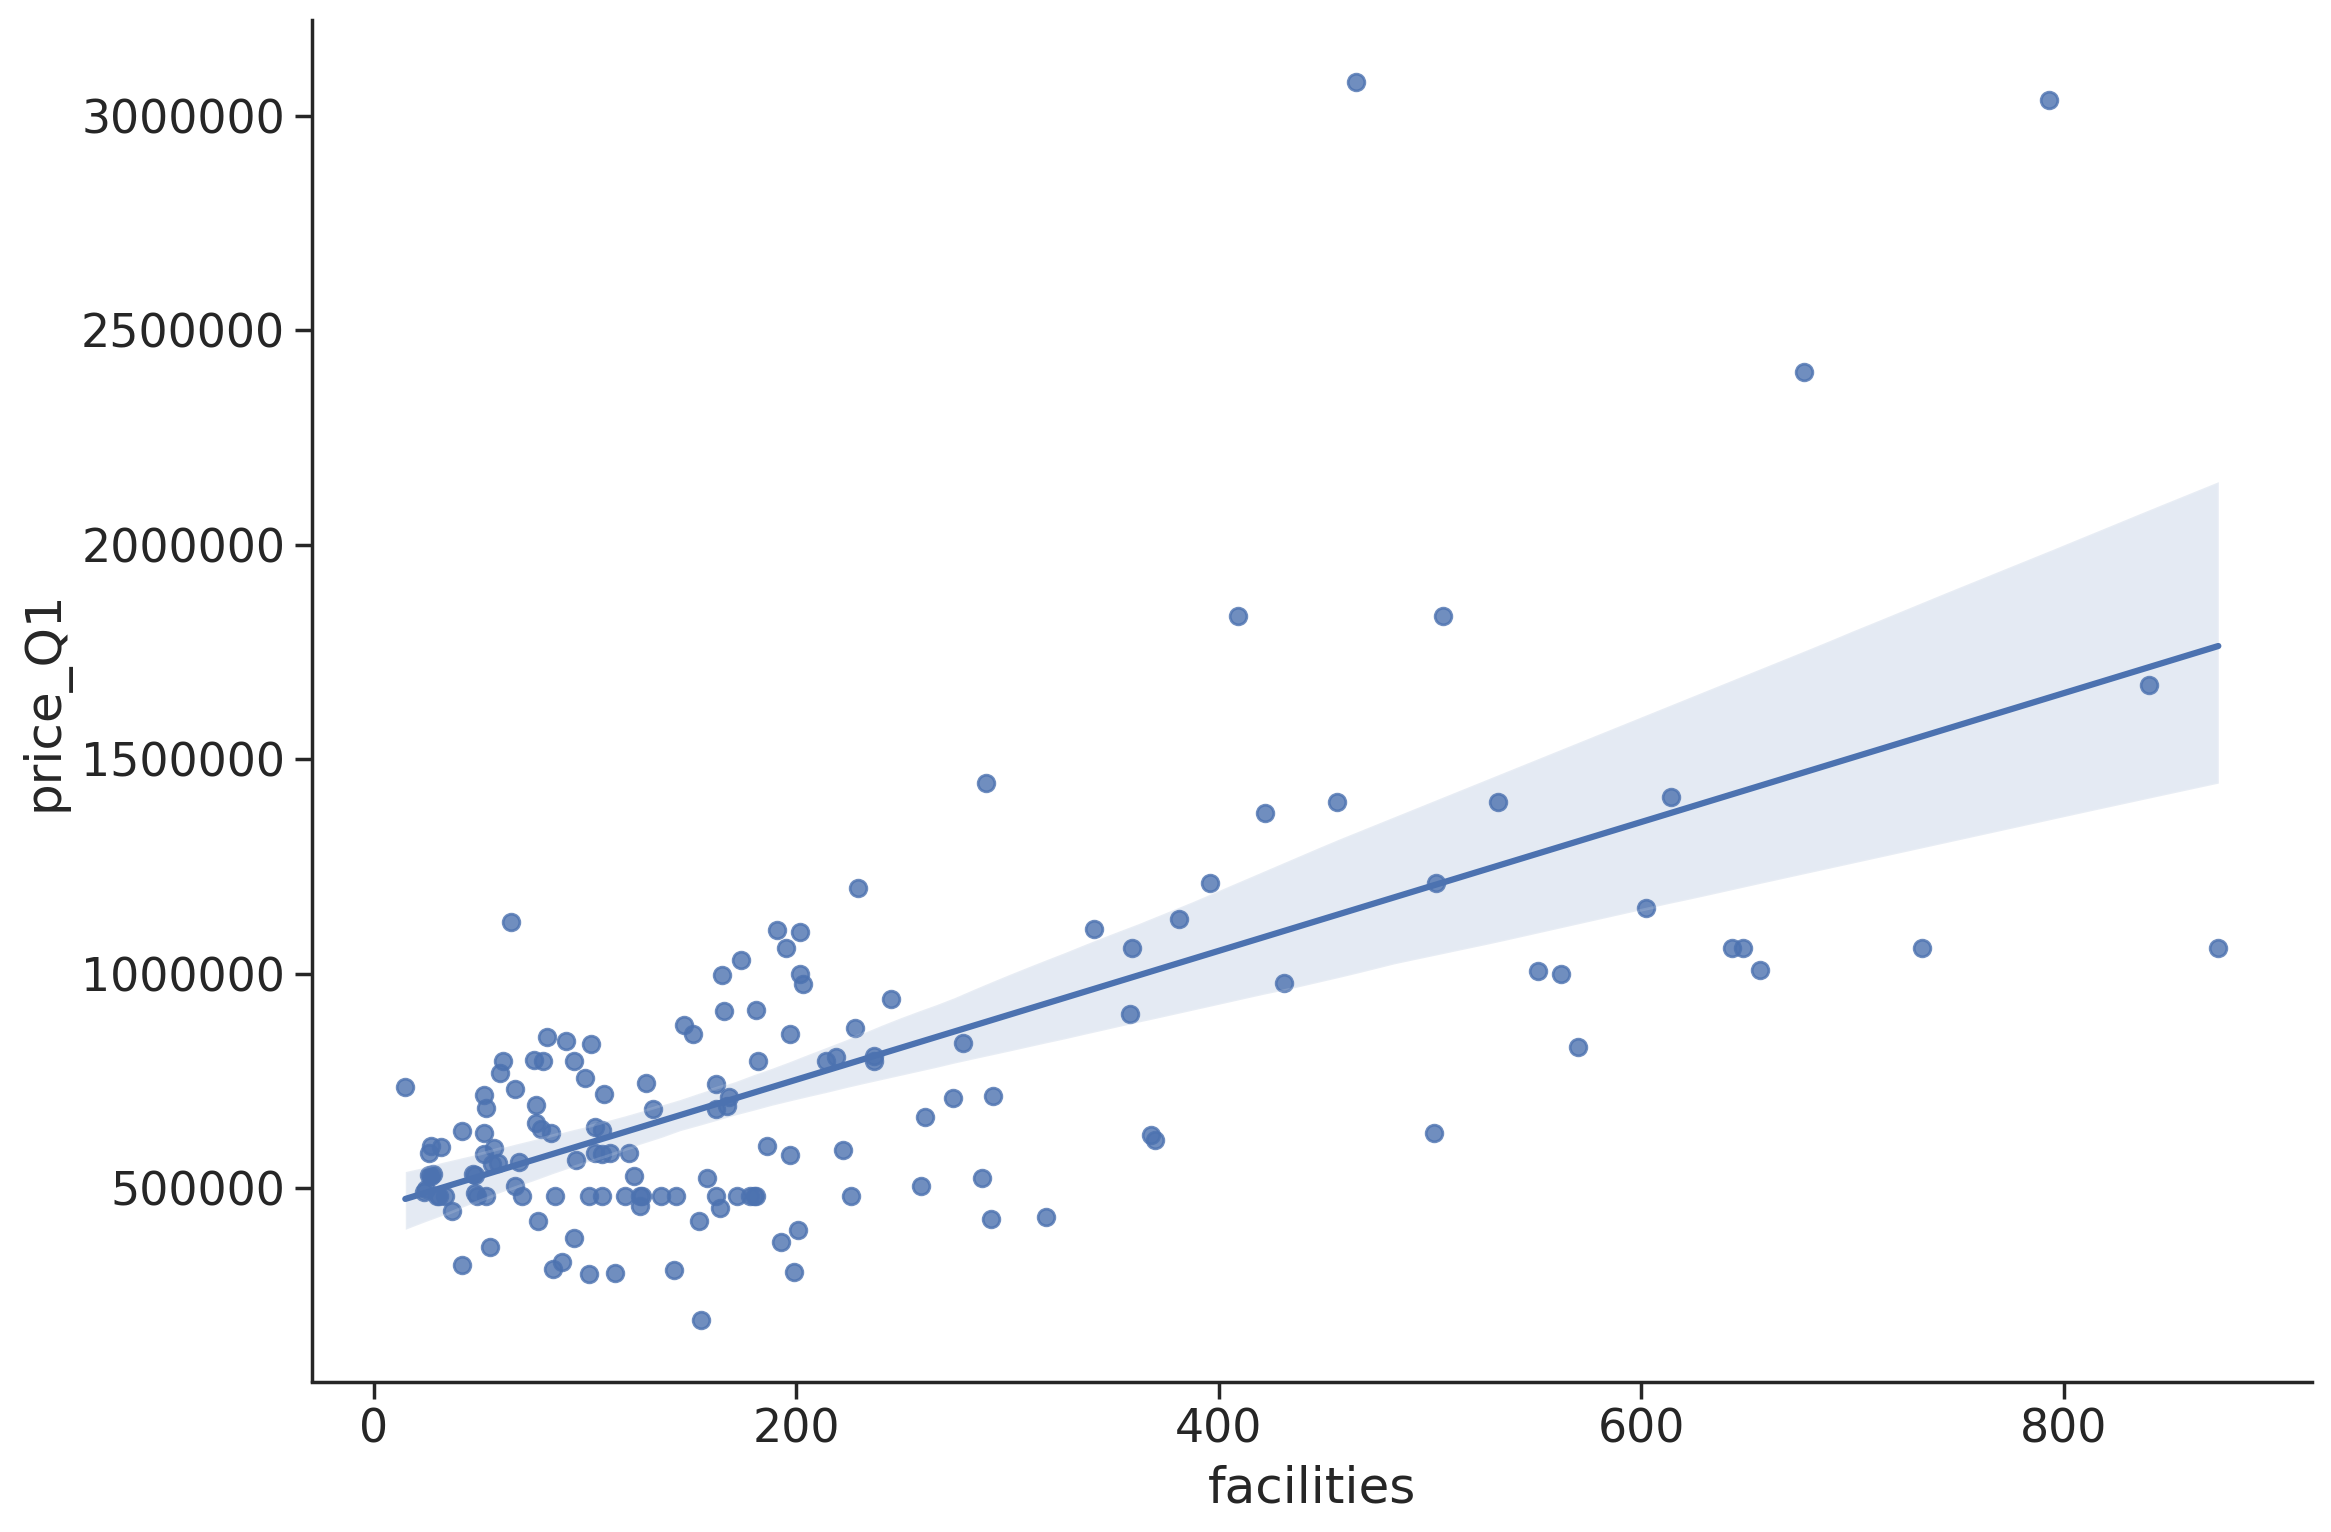

In [767]:
sns.set(style='ticks',font_scale=1.5)
sns.lmplot(data=cluster1, x='facilities',y='price_Q1',palette="deep",
            aspect=1.5,height=8)

In [655]:
bar = cluster1[['Cluster Labels','food drink','school','medical','outdoors recreation','residence']]

In [656]:
bar

,Cluster Labels,food drink,school,medical,outdoors recreation,residence
0,1,14,7,14,5,7
1,1,10,8,32,15,5
2,1,13,6,7,5,3
3,1,8,15,44,29,6
4,1,34,36,67,55,7
5,0,30,38,71,45,11
6,1,12,6,20,10,5
7,1,25,25,87,33,2
8,1,23,29,19,7,6
9,1,12,16,64,12,4


In [661]:
tidy = pd.melt(bar, id_vars="Cluster Labels")

In [662]:
tidy

,Cluster Labels,variable,value
0,1,food drink,14
1,1,food drink,10
2,1,food drink,13
3,1,food drink,8
4,1,food drink,34
5,0,food drink,30
6,1,food drink,12
7,1,food drink,25
8,1,food drink,23
9,1,food drink,12


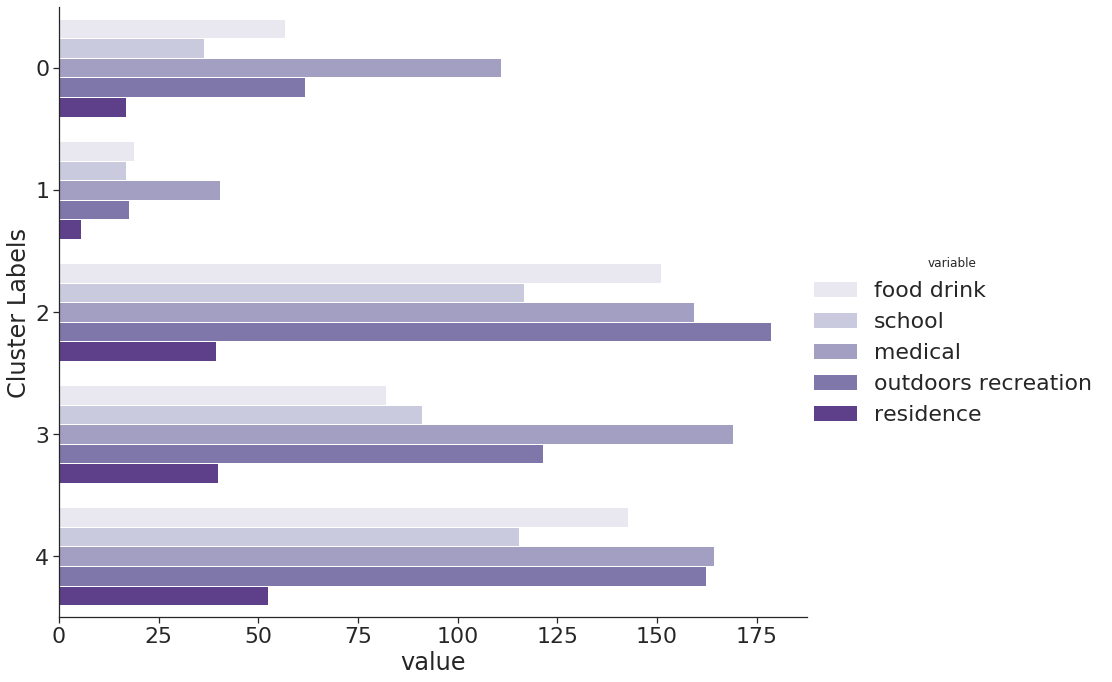

In [680]:
sns.set(style='ticks',font_scale=2)
sns.catplot(data=tidy, y='Cluster Labels',x='value',kind='bar',
            hue='variable',height=10,aspect=1.2,ci=False,
           palette='Purples',orient='h')

<p style='font-size:16px;'> Based on the K-means clustering, there are 5 distinct clusters that can be used to segment neighborhoods in NYC:</p>

<p style='font-size:16px;'><strong> Cluster 1</strong>: <br>
These neighborhoods tend to be near the center of Manhattan, with medium housing prices around $800,000 as well as a variety of facilities available. The commute time is on average 20-30 minutes to midtown. They are suitable for people who are looking for homes with high quality-price-ratio, and enjoy relatively short commutes as well as quietness.</p>

<p style='font-size:16px;'><strong>Cluster 2</strong>: <br>
If you are looking for purchsing a home but with limited budget, look no further. This cluster includes neighborhoods in Bronx, Queens as well as Brooklyn that are comparatively far away from the center of Manhattan. But the average housing price is about $500,000, with limited facilities nearby.</p>

<p style='font-size:16px;'><strong>Cluster 3</strong>: <br>
These neighborhoods sit in the middle of Manhattan, with average sales price of $2-3 millions. They all have an abundance of facilities, such as food and drinks, medical centers as well as recreation space. They are suitable for people with substantial amount of money and would like to enjoy city life.</p>

<p style='font-size:16px;'><strong>Cluster 4</strong>: <br>
It is funny that the algorithem put upper west side and upper east side in a cluster. These two neighborhoods are famous for their quiteness, closeness to central park, an array of medical services as well as an abundance of housing inventory.</p> 

<p style='font-size:16px;'><strong>Cluster 5</strong>: <br>
These neighborhoods are also either in Manhattan or in very close proximity to Mahattan, with the average housing price being around $1 million. They are good choices for people who love city life but are not ultra rich. </p>


# Conclusion

<p style='font-size:16px;'>As milennials are reaching the ages of becoming home owners, picking a place to purchase is a huge task and problem for many people. </p>

<p style='font-size:16px;'>This project used K-means clustering algorithm as well as location /real estate data to help segrement neighborhoods in NYC into 5 categories, which suit the needs of people with different budgets, as well as preferences of various facilities such as schools and medical centers. </p>

<p style='font-size:16px;'>However, there are certain limitations of the project: as the real estate data obtained from StreetEasy does not contain neighborhoods in Staten Island, the final clustering does not include the majority of neighborhoods in Staten Island. People who are interested in furthering this project, should try to include these data.</p>

<p style='font-size:16px;'>To conclude, customers with a substantial amount of money and enjoying city life could go with cluster 2; customers who enjoys city life but are not willing to pay $2-3 millions for their homes should pick cluster 3; customers who would like to be close to central park and an abundannce of medical centers/schools can choose cluster 4; customers who enjoys the proximity of Manhattan, but would like some quietness and have medium amout of budget can select cluster 1; and finally, customers who have limited budget and do not mind long commutes to midtown can pick cluster 5. </p>